## Sentence Transformers

There is a new version with some features I figured that I might give a spin.


In [1]:
from datasets import load_dataset

dataset = load_dataset("m3hrdadfi/recipe_nlg_lite")

/Users/vincent/Development/probabl/venv/lib/python3.11/site-packages/datasets/load.py:1429: FutureWarning: The repository for m3hrdadfi/recipe_nlg_lite contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/m3hrdadfi/recipe_nlg_lite
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
/Users/vincent/Development/probabl/venv/lib/python3.11/site-packages/huggingface_hub/repocard.py:105: UserWarning: Repo card metadata block was not found. Setting CardData to empty.
  warnings.warn("Repo card metadata block was not found. Setting CardData to empty.")


In [2]:
dataset

DatasetDict({
    train: Dataset({
        features: ['uid', 'name', 'description', 'link', 'ner', 'ingredients', 'steps'],
        num_rows: 6118
    })
    test: Dataset({
        features: ['uid', 'name', 'description', 'link', 'ner', 'ingredients', 'steps'],
        num_rows: 1080
    })
})

In [3]:
recipe_names = dataset['train']['name']

In [4]:
from sentence_transformers import SentenceTransformer

In [5]:
tfm_base = SentenceTransformer("tomaarsen/mpnet-base-nli")

In [6]:
%%time

X_tfm = tfm_base.encode(recipe_names)

CPU times: user 8.79 s, sys: 1.46 s, total: 10.3 s
Wall time: 24.7 s


In [7]:
X_tfm.shape

(6118, 768)

In [8]:
tfm_mat = SentenceTransformer("tomaarsen/mpnet-base-nli-matryoshka")

In [9]:
%%time

X_matr = tfm_mat.encode(recipe_names)

CPU times: user 6.77 s, sys: 1.23 s, total: 8 s
Wall time: 22.7 s


In [10]:
X_matr.shape

(6118, 768)

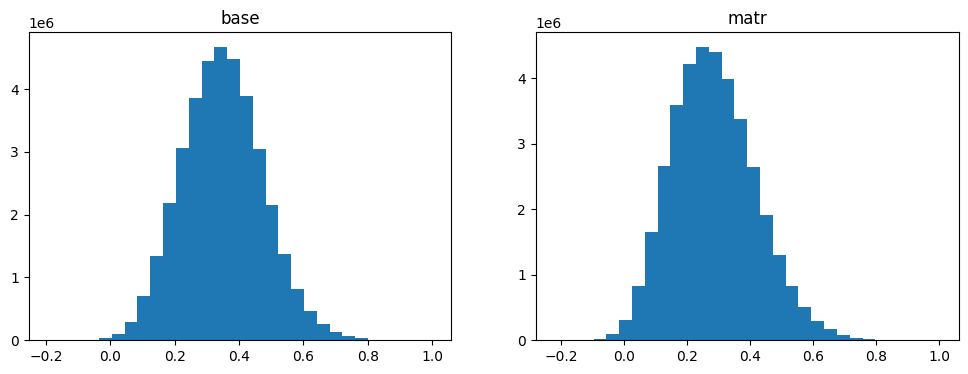

In [11]:
import matplotlib.pylab as plt
from sklearn.metrics.pairwise import cosine_similarity

base_sims = cosine_similarity(X_tfm, X_tfm).ravel()
matr_sims = cosine_similarity(X_matr, X_matr).ravel()

plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.hist(base_sims, bins=30);
plt.title('base')
plt.subplot(122)
plt.hist(matr_sims, bins=30);
plt.title('matr');

In [12]:
import numpy as np

In [74]:
from sklearn.decomposition import PCA


In [82]:
data = []

for i in [8, 16, 32, 64, 128, 256]:
    print(i)
    pca_out = PCA(n_components=i).fit(X_tfm).transform(X_tfm)
    pca_reduced = cosine_similarity(pca_out, pca_out).ravel()
    base_reduced = cosine_similarity(X_tfm[:, :i], X_tfm[:, :i]).ravel()
    matr_reduced = cosine_similarity(X_matr[:, :i], X_matr[:, :i]).ravel()
    base_corr, matr_corr = np.corrcoef(base_sims, base_reduced)[0,1], np.corrcoef(matr_sims, matr_reduced)[0,1]
    pca_corr = np.corrcoef(base_sims, pca_reduced)[0,1]
    data.append({'i': i, 'base': base_corr, 'matr_corr': matr_corr, 'pca': pca_corr})    

8
16
32
64
128
256


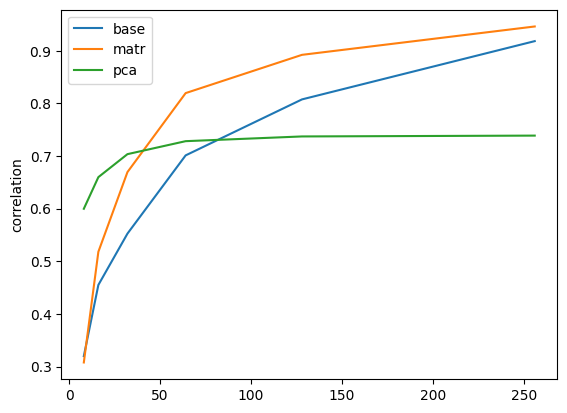

In [84]:
import pandas as pd

pltr = pd.DataFrame(data)

plt.plot(pltr['i'], pltr['base'], label='base')
plt.plot(pltr['i'], pltr['matr_corr'], label='matr')
plt.plot(pltr['i'], pltr['pca'], label='pca')

plt.legend()
plt.ylabel('correlation');

In [19]:
from sentence_transformers import SentenceTransformer
from sentence_transformers.util import cos_sim
from sentence_transformers.quantization import quantize_embeddings

# 1. Specify preffered dimensions
dimensions = 512

# 2. load model
model = SentenceTransformer("all-MiniLM-L6-v2", truncate_dim=dimensions)
docs = recipe_names[:1000]

# 2. Encode
embeddings = model.encode(docs)

# Optional: Quantize the embeddings
binary_embeddings = quantize_embeddings(embeddings, precision="ubinary")

In [67]:
binary_embeddings

array([[102, 160, 134, ...,  79, 221, 112],
       [ 30, 227, 207, ...,   9, 126, 182],
       [ 86, 162, 197, ...,  43,  86, 253],
       ...,
       [ 62, 161, 219, ..., 104, 204, 163],
       [ 86, 130, 162, ..., 224,  18, 109],
       [ 35, 128, 163, ..., 193, 111, 174]], dtype=uint8)

In [35]:
embeddings.nbytes, binary_embeddings.nbytes

(1536000, 48000)

In [68]:
unpacked = np.array([
    np.unpackbits(binary_embeddings[i]) for i in range(binary_embeddings.shape[0])
])

In [31]:
similarities_orig = cosine_similarity(embeddings[0].reshape(1, -1), embeddings[1:])
similarities_bin = cosine_similarity(unpacked[0].reshape(1, -1), unpacked[1:])

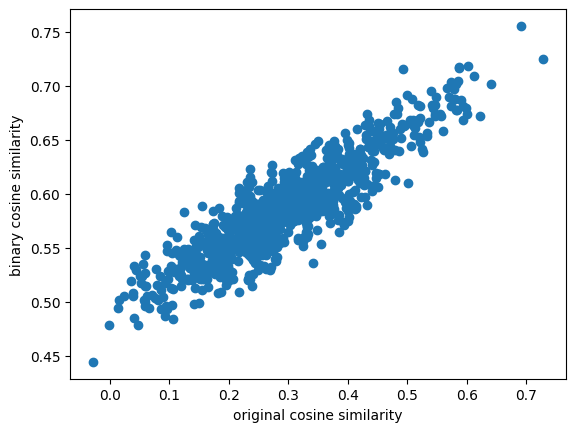

In [58]:
plt.scatter(similarities_orig, similarities_bin)
plt.ylabel('binary cosine similarity')
plt.xlabel('original cosine similarity');

In [59]:
import numba

@numba.jit(fastmath=True)
def binpacked_overlap(x, y):
    count = 0
    for mod in range(8):
        xi = x % 2**(mod + 1) // 2**mod
        yi = y % 2**(mod + 1) // 2**mod
        for i in range(x.shape[0]):
            count += (xi[i] == yi[i])
    return count

In [60]:
plain_overlap = np.array([binpacked_overlap(binary_embeddings[0], binary_embeddings[i]) 
                          for i in range(1, embeddings.shape[0])])

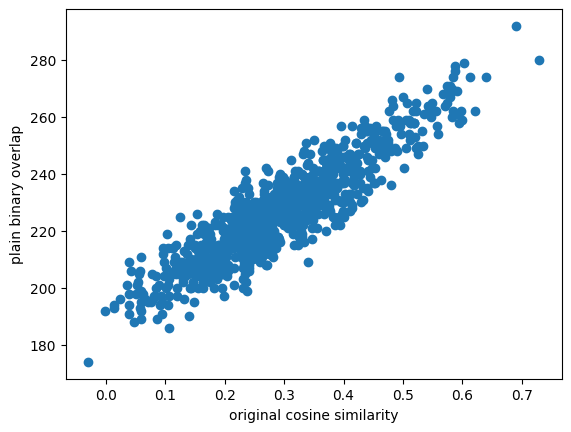

In [61]:
plt.scatter(similarities_orig, plain_overlap)
plt.ylabel('plain binary overlap')
plt.xlabel('original cosine similarity');